In [1]:
from casadi import *
import numpy as np
import dpilqr
import matplotlib.pyplot as plt
from solvers import util
from time import perf_counter

### Regular centralized MPC, no consensus

In [2]:
def linear_kinodynamics(dt,n_agent):
    #Decision vector is a = [a_x, a_y, a_z]
    #State vector is X = [p_x, p_y, p_z, v_x, v_y, v_z]
    #Discretization time step is dt
    A_tot = np.zeros((6*n_agent, 6*n_agent))
    B_tot = np.zeros((6*n_agent, 3*n_agent))
    A = np.array([[1, 0, 0, dt, 0, 0],
                           [0, 1, 0, 0 , dt ,0],\
                           [0, 0, 1, 0, 0 , dt],\
                           [0, 0, 0, 1, 0 ,0],\
                           [0, 0, 0, 0, 1 ,0],\
                           [0, 0, 0, 0, 0, 1]])
    B = np.array([[dt**2/2, 0, 0],\
                           [0, dt**2/2, 0],\
                           [0, 0, dt**2/2],\
                           [dt, 0, 0 ],\
                           [0, dt , 0],\
                           [0, 0, dt]])

    for i in range(n_agent):
        A_tot[i*6:(i+1)*6,i*6:(i+1)*6] = A
        B_tot[i*6:(i+1)*6,i*3:(i+1)*3] = B
        
    
    return A_tot, B_tot

In [3]:
"""Define constants"""
n_states = 6
n_inputs = 3
n_agents = 3
nx = n_states*n_agents
nu = n_inputs*n_agents
x0,xr = util.paper_setup_3_quads()
N = n_agents
T = 8
Q = np.diag([5., 5., 5., 1., 1., 1.]*N)
Qf = Q*500
R = 0.1*np.eye(N*n_inputs)
radius = 0.5
Ad, Bd = linear_kinodynamics(0.1, N)

In [4]:
x0, xr = util.paper_setup_3_quads()


In [5]:
opti = Opti()
Y_state = opti.variable((T+1)*nx + T*nu)
cost = 0
for t in range(T):
    for idx in range(nx):
        cost += (Y_state[:(T+1)*nx][t*nx:(t+1)*nx][idx]-xr[idx]) *  \
        Q[idx,idx]* (Y_state[:(T+1)*nx][t*nx:(t+1)*nx][idx]-xr[idx]) 
    for idu in range(nu):
        cost += (Y_state[(T+1)*nx:][t*nu:(t+1)*nu][idu]) *  \
        R[idu,idu] * (Y_state[(T+1)*nx:][t*nu:(t+1)*nu][idu])

for idf in range(nx):
    cost += (Y_state[:(T+1)*nx][T*nx:(T+1)*nx][idf] - xr[idf]) * \
    Qf[idf,idf] * (Y_state[:(T+1)*nx][T*nx:(T+1)*nx][idf] - xr[idf])

In [6]:
#what happens if collision cost is removed??

In [7]:
coll_cost = 0
smooth_trj_cost = 0
solution_trj = []
obj_hist = []
x_curr = x0

X_trj = np.zeros((0, nx))
U_trj = np.zeros((0, nu))
X_trj = np.r_[X_trj, x0.T]
iters = 0

solve_times = []

while not np.all(dpilqr.distance_to_goal(x_curr.flatten(), xr.flatten(), n_agents, n_states, 3) <= 0.1):

    for k in range(T):
        
        opti.subject_to(Y_state[:(T+1)*nx][(k+1)*nx:(k+2)*nx] \
                        == Ad @ Y_state[:(T+1)*nx][k*nx:(k+1)*nx] \
                            + Bd @ Y_state[(T+1)*nx:][k*nu:(k+1)*nu])

        opti.subject_to(Y_state[(T+1)*nx:][k*nu:(k+1)*nu] <= np.tile(np.array([3, 3, 3]),(N,)).reshape(-1,1))
        opti.subject_to(np.tile(np.array([-3, -3, -3]),(N,)).reshape(-1,1) <= Y_state[(T+1)*nx:][k*nu:(k+1)*nu])

        #Pair-wise Euclidean distance between each pair of agents
        distances = util.compute_pairwise_distance_nd_Sym(Y_state[:(T+1)*nx][k*nx:(k+1)*nx],[6,6,6], [3,3,3])
        #Collision avoidance cost
        for dist in distances:
            # coll_cost += fmin(0,(dist - radius))**2 * 300
            coll_cost += fmin(0,(dist - radius))**2 * 1200

        #Smoothing term
        for ind in range(nx):
            smooth_trj_cost += (Y_state[:(T+1)*nx][(k+1)*nx:(k+2)*nx][ind]-\
                                Y_state[:(T+1)*nx][k*nx:(k+1)*nx][ind])**2
    
    X0 = opti.parameter(x0.shape[0],1)    
    # opti.subject_to(Y_state[0:nx] == x_curr) 
    opti.subject_to(Y_state[0:nx] == X0)
    
    cost_tot = cost + coll_cost + smooth_trj_cost
    opti.minimize(cost_tot)

    opti.solver("ipopt")
    opti.set_value(X0,x_curr)
    
    if iters > 0:
        opti.set_initial(sol_prev.value_variables())
        
    t0 = perf_counter()
    sol = opti.solve()
    sol_prev = sol
    solve_times.append(perf_counter() - t0)
    obj_hist.append(sol.value(cost_tot))
    
    ctrl = sol.value(Y_state)[(T+1)*nx:].reshape((T, nu))[0]
    # x_curr = Ad@x_curr + (Bd @ ctrl).reshape(-1,1) #Apply first element in the control sequence
    x_curr = sol.value(Y_state)[:(T+1)*nx].reshape((T+1,nx))[1]
    X_trj = np.r_[X_trj, x_curr.reshape(1,-1)]
    U_trj = np.r_[U_trj, ctrl.reshape(1,-1)]
    
    opti.subject_to()
    
    iters += 1
    


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     4050
Number of nonzeros in inequality constraint Jacobian.:      144
Number of nonzeros in Lagrangian Hessian.............:      666

Total number of variables............................:      234
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      162
Total number of inequality c

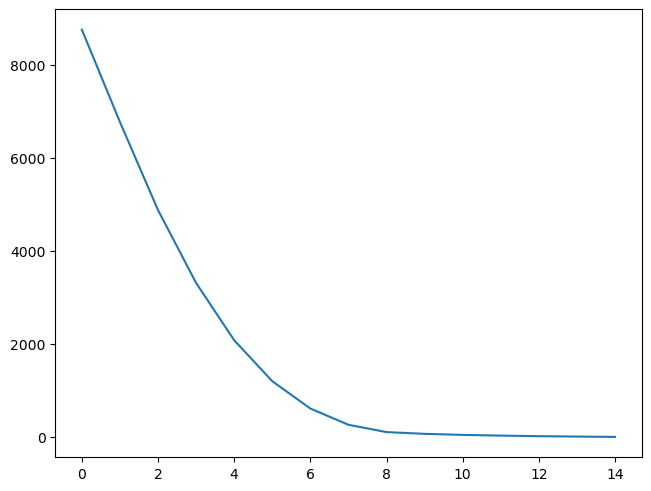

In [8]:
plt.figure()
plt.plot(obj_hist)

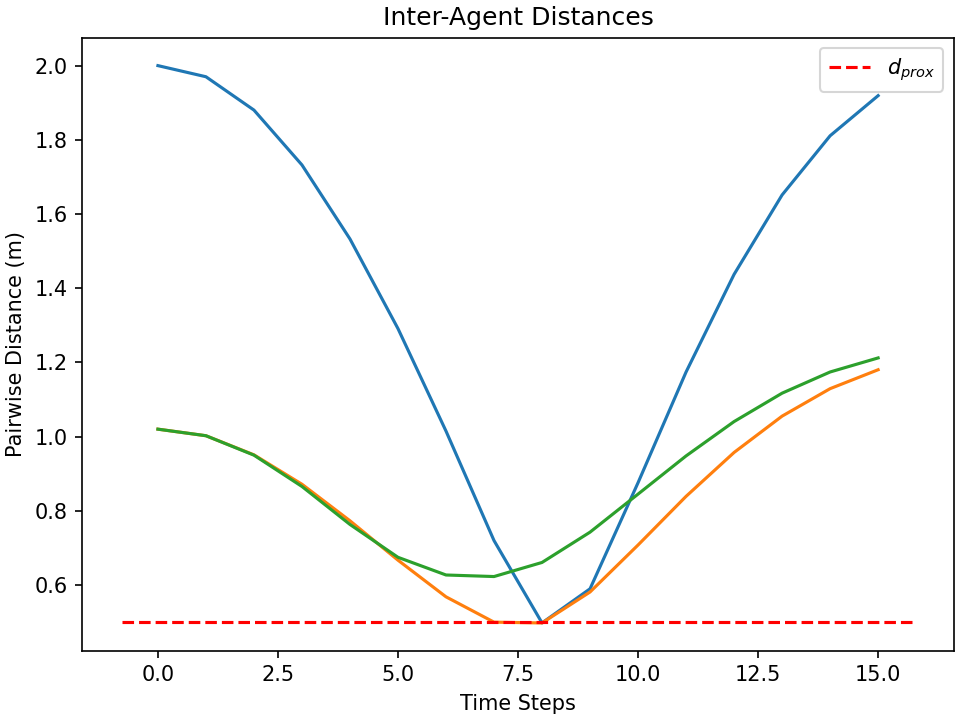

In [41]:
plt.figure(dpi=150)
dpilqr.plot_pairwise_distances(X_trj,[6,6,6],[3,3,3],radius)

In [42]:
u_ref = np.array([0, 0, 0]*n_agents)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


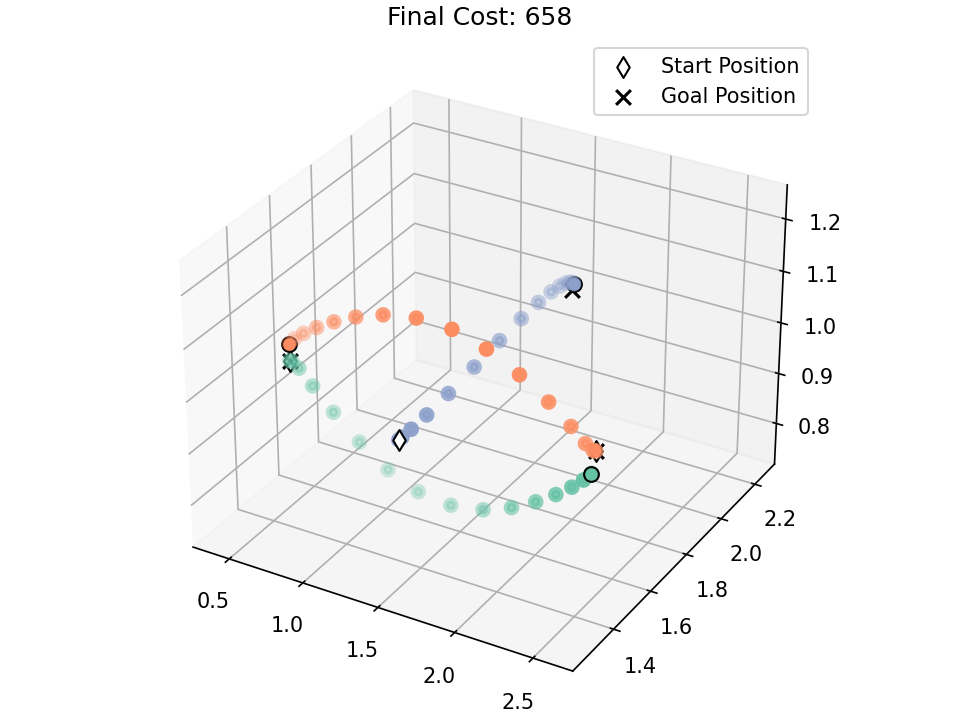

In [43]:
%matplotlib ipympl
plt.figure(dpi=150);
dpilqr.plot_solve(X_trj, float(util.objective(X_trj.T, U_trj.T, u_ref, xr, Q, R, Qf)), xr, [6,6,6], True, 3);
plt.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"])
plt.savefig('Casadi_MPC_demo.png')

In [31]:
dpilqr.distance_to_goal(X_trj[-1].reshape(-1,1),xr, 3, 6, 3)

array([0.068, 0.069, 0.013])

In [32]:
np.mean(solve_times)

0.3401149533339776

In [33]:
np.std(solve_times)

0.11999386112519582

In [34]:
U_trj.shape

(15, 9)

In [35]:
X_trj.shape

(16, 18)

In [36]:
u_ref = np.array([0, 0, 0]*n_agents)